In [37]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy.io.wavfile as wavfile

from tensorflow.keras import layers, models

In [38]:
FILE_PATH = './donateacry_corpus'
dataset = pathlib.Path(FILE_PATH)
cry_list = np.array(tf.io.gfile.listdir(str(dataset)))
print(cry_list) 

['belly_pain' 'burping' 'discomfort' 'hungry' 'tired']


In [39]:
train_set, val_set = tf.keras.utils.audio_dataset_from_directory(
    directory=FILE_PATH,
    batch_size=16,
    seed=0,
    validation_split=.2,
    output_sequence_length=16000,
    subset='both'
)

label_names = np.array(train_set.class_names)
print(label_names)

Found 457 files belonging to 5 classes.
Using 366 files for training.
Using 91 files for validation.
['belly_pain' 'burping' 'discomfort' 'hungry' 'tired']


In [40]:
def squeeze(audio, label):
    audio=tf.squeeze(audio, axis=-1)
    return audio, label

train_set = train_set.map(squeeze, tf.data.AUTOTUNE)
val_set = val_set.map(squeeze, tf.data.AUTOTUNE)

test_set = val_set.shard(num_shards=2, index=0)
val_set = val_set.shard(num_shards=2, index=1)

In [41]:
def get_spectogram(waveform):
    spectogram=tf.signal.stft(
        signals=waveform,
        frame_length=255,
        frame_step=128
    )
    spectogram=tf.abs(spectogram)
    spectogram=spectogram[..., tf.newaxis]
    return spectogram

def make_spectogram_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_spectogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

In [42]:
train_set_spec = make_spectogram_ds(train_set).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_set_spec = make_spectogram_ds(val_set).cache().prefetch(tf.data.AUTOTUNE)
test_set_spec = make_spectogram_ds(test_set).cache().prefetch(tf.data.AUTOTUNE)

In [43]:
for example_case, example_case_label in train_set_spec.take(1):
    break

In [44]:
input_shape = example_case.shape[1:]
num_label = len(cry_list)
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_set_spec.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(.5),
    layers.Dense(num_label)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_2 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 64)       

In [45]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [46]:
history = model.fit(
    train_set_spec,
    validation_data=val_set_spec,
    epochs=10,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=3, verbose=3)
)

Epoch 1/10
23/23 [==============================] - 2s 51ms/step - loss: 0.9806 - accuracy: 0.7923 - val_loss: 0.6256 - val_accuracy: 0.9070
Epoch 2/10
23/23 [==============================] - 1s 32ms/step - loss: 0.7560 - accuracy: 0.8279 - val_loss: 0.4341 - val_accuracy: 0.9070
Epoch 3/10
23/23 [==============================] - 1s 35ms/step - loss: 0.6693 - accuracy: 0.8279 - val_loss: 0.5198 - val_accuracy: 0.9070
Epoch 4/10
23/23 [==============================] - 1s 35ms/step - loss: 0.6337 - accuracy: 0.8333 - val_loss: 0.4360 - val_accuracy: 0.9070
Epoch 5/10
23/23 [==============================] - 1s 37ms/step - loss: 0.5682 - accuracy: 0.8415 - val_loss: 0.4640 - val_accuracy: 0.9070
Epoch 5: early stopping


In [47]:
model.save('cry_classification_model.h5')

In [48]:
ctr=0
for i , (spectogram, label) in enumerate(test_set_spec):
    pred = model.predict(spectogram)
    pred_label_idx = tf.argmax(pred, axis=1).numpy()
    orig_label = label_names[label.numpy()]
    pred_label = [label_names[idx] for idx in pred_label_idx]
    for j, label in enumerate(orig_label):
        ctr+=1
        print(f'Data-{ctr}: label: {label} -> predicted: {pred_label[j]}') 
    

1/1 [==============================] - 0s 82ms/step
Data-1: label: hungry -> predicted: hungry
Data-2: label: hungry -> predicted: hungry
Data-3: label: hungry -> predicted: hungry
Data-4: label: hungry -> predicted: hungry
Data-5: label: hungry -> predicted: hungry
Data-6: label: tired -> predicted: hungry
Data-7: label: hungry -> predicted: hungry
Data-8: label: hungry -> predicted: hungry
Data-9: label: hungry -> predicted: hungry
Data-10: label: hungry -> predicted: hungry
Data-11: label: hungry -> predicted: hungry
Data-12: label: hungry -> predicted: hungry
Data-13: label: hungry -> predicted: hungry
Data-14: label: hungry -> predicted: hungry
Data-15: label: hungry -> predicted: hungry
Data-16: label: hungry -> predicted: hungry
1/1 [==============================] - 0s 26ms/step
Data-17: label: hungry -> predicted: hungry
Data-18: label: hungry -> predicted: hungry
Data-19: label: hungry -> predicted: hungry
Data-20: label: hungry -> predicted: hungry
Data-21: label: discomfort

In [49]:
test_result = model.evaluate(test_set_spec, return_dict=True)
accuracy = test_result['accuracy']
print("Accuracy on test set = {:.2f}%".format(accuracy*100))

1/3 [=========>....................] - ETA: 0s - loss: 0.3449 - accuracy: 0.9375

3/3 [==============================] - 0s 8ms/step - loss: 0.8712 - accuracy: 0.8333
Accuracy on test set = 83.33%


Text(0, 0.5, 'Accuracy [%]')

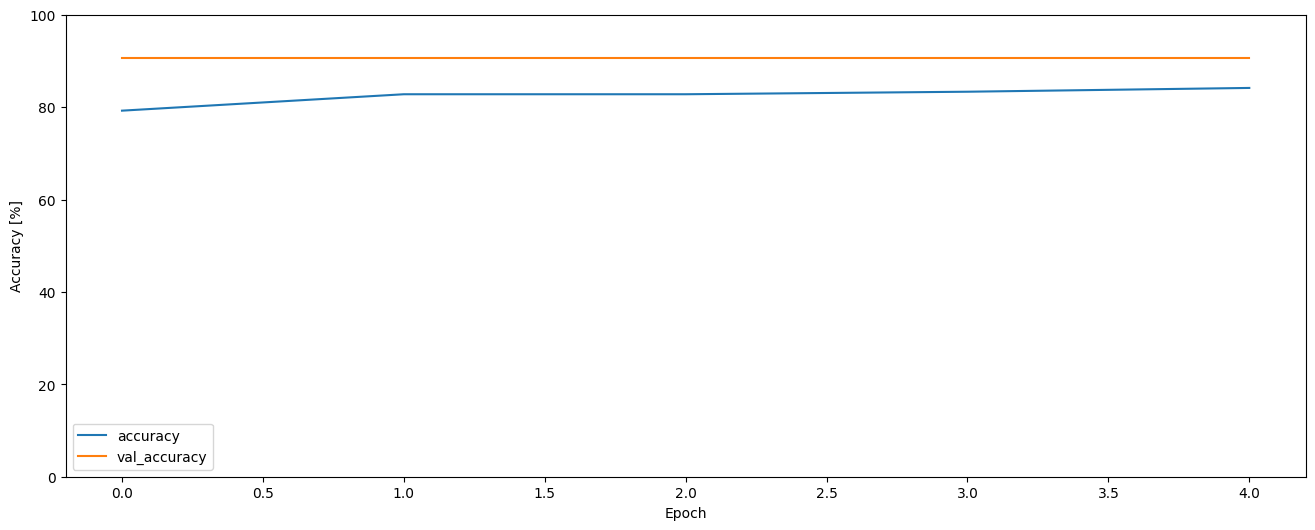

In [50]:
metrics = history.history
plt.figure(figsize=(16,6)),
plt.plot(history.epoch,100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0,100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')